Install necessary packages

In [ ]:
pip install -r /workspaces/uzh-digfintools-research/resources/requirementsshort.txt


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Equity data - D&J 60 from 2019-11-01 to 2020-11-01 (source: finance yahoo)

In [1]:
import yfinance as yf
import pandas as pd
import os

#tickers = [
    #'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
    #'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM',
    #'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'VZ', 'V',
    #'WBA', 'WMT', 'RTX', 'TSLA', 'META', 'GOOGL', 'GOOG', 'NFLX', 'AMZN', 'BMY', 'PEP',
    #'ORCL', 'QCOM', 'TXN', 'ADP', 'COST', 'GE', 'MO', 'ABT', 'T',
    #'SBUX', 'LLY', 'BRK-B', 'PFE', 'XOM', 'MDT', 'TGT', 'SPGI',
    #'BK', 'C', 'SLB', 'DHR', 'DUK'
#]

tickers = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DOW", "XOM", "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "VZ", "V", "WBA", "WMT", "DIS", "RTX"]

start_date = '2019-11-01'
end_date = '2020-11-01'

data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']
#file_path = os.path.join('/workspaces/uzh-digfintools-research/data/raw','DJ60_securities.csv')
#data.to_csv(file_path)


[*********************100%***********************]  30 of 30 completed


Risk-free data - T-bill 10Y yield for the same time period (source: finance yahoo)

In [2]:
import yfinance as yf
import pandas as pd
import os

ticker = "^TNX"

y10_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
y10_data.head()
rf_rate = y10_data/100

#file_path1 = os.path.join('/workspaces/uzh-digfintools-research/data/raw','10Y_Treasury_Yield.csv')
#rf_rate.to_csv(file_path1)
#print(y10_data)
descriptive_stats = rf_rate.describe()
descriptive_stats.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^TNX
count,252.000000
mean,0.010363
std,0.005018
min,0.004990
25%,0.006627


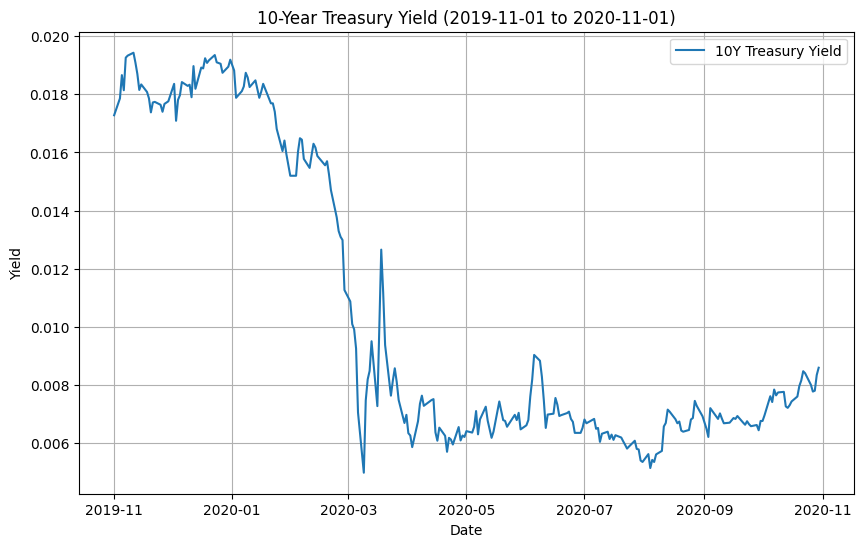

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(rf_rate, label='10Y Treasury Yield')
plt.title('10-Year Treasury Yield (2019-11-01 to 2020-11-01)')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()


Descriptive Statistics (First 4 moments):
             Mean  Variance  Skewness   Kurtosis
Ticker                                         
AAPL    0.002119  0.000835 -0.339678   4.412624
AXP    -0.001063  0.001393  0.404604   7.388946
BA     -0.003472  0.002904 -0.324005   6.213240
CAT     0.000332  0.000755 -0.813714   5.031456
CSCO   -0.001076  0.000701 -0.366127   6.532870
CVX    -0.002048  0.001387 -1.117807  14.373045
DIS    -0.000361  0.000818 -0.087196   5.781615
DOW    -0.000557  0.001520 -1.129871   9.674741
GS     -0.000557  0.001040 -0.154397   6.422341
HD      0.000465  0.000792 -1.931863  18.186764
IBM    -0.000772  0.000651 -0.508216   5.595382
INTC   -0.000972  0.001115 -0.865250  11.892228
JNJ     0.000176  0.000356  0.188884   5.479419
JPM    -0.001056  0.001069 -0.205374   6.741553
KO     -0.000457  0.000458 -0.773735   4.139190
MCD     0.000373  0.000635 -0.286611  18.110357
MMM    -0.000245  0.000564 -0.188572   4.950028
MRK    -0.000485  0.000390 -0.105445   4.331

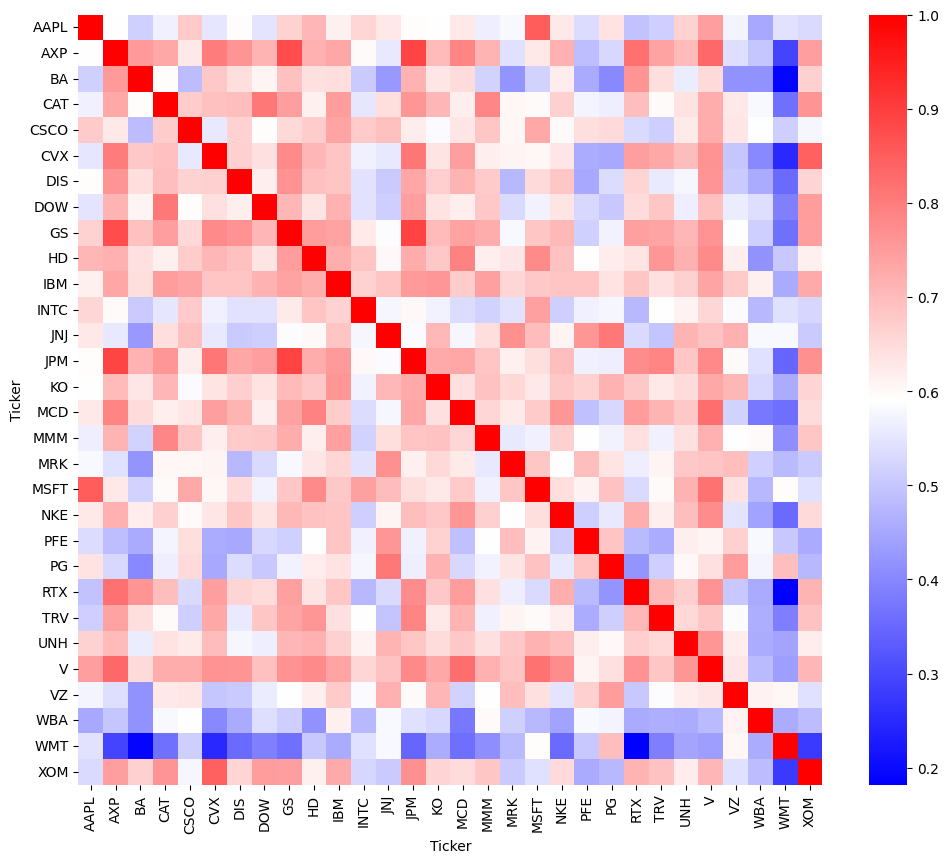

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Descriptive statistics (First 4 moments)
mean_returns = log_returns.mean()
variance = log_returns.var()
skewness = log_returns.skew()
kurtosis = log_returns.kurtosis()

# Combine the descriptive statistics into a DataFrame
descriptive_stats = pd.DataFrame({
    'Mean': mean_returns,
    'Variance': variance,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

# Calculate the correlation matrix
correlation_matrix = log_returns.corr()

# Display descriptive statistics

print("\nDescriptive Statistics (First 4 moments):\n", descriptive_stats)


correlation_matrix = log_returns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='bwr') #account for colorblind color palette

# Display the plot
plt.show()

In [8]:
#Define target portfolio return as average daily return of DJ in October 2019

import yfinance as yf
import pandas as pd
import os
import numpy as np

ticker = "^DJI"
dji_data = yf.download(ticker, start='2019-10-01', end='2019-10-31', interval='1d')['Close']
dji_log_returns = np.log(dji_data / dji_data.shift(1)).dropna()
p0 = np.mean(dji_log_returns)
print(p0)


[*********************100%***********************]  1 of 1 completed

0.001087160118374933


Markowtiz optimisation set up

In [42]:
import numpy as np


fc = 21 #forecasting period: 21 - monthly
rb = 10 #rebalancing: 10 - biweekly
n = log_returns.shape[1] #number of securities
tdays = log_returns.shape[0]
tperiods = int(( tdays - fc) / rb) - 1 #number of forecasting periods
eqw = np.full(n, 1 / n)  # Equally weighted portfolio


results_minvar = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}


results_maxsr = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}

riskfree_rate = rf_rate.values

Minimum variance optimisation

In [43]:
import cvxopt
import numpy as np

cvxopt.solvers.options['show_progress'] = False

for i in range(tperiods):
    # Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)


    # Initialize quadratic programming problem to minimise variance
    P = 2 * cvxopt.matrix(window_cov.values) # Covariance matrix (for variance minimization)
    q = cvxopt.matrix(np.zeros(n)) # No linear term in minimisation problem

    # Constraints: no short selling (weights >= 0) and minimum portfolio return constraint
    G = cvxopt.matrix(np.vstack([-np.eye(n), log_returns_target]))
    h = cvxopt.matrix(np.append(np.zeros(n), -p0))

    # Fully invested portfolio: sum of weights = 1
    A = cvxopt.matrix(np.ones([1, n]))
    b = cvxopt.matrix([1.0])

    #Run optimisation problem
    sol = cvxopt.solvers.qp(P,q, G, h, A, b)

    #Check for optimisation failures
    if sol['status'] != 'optimal':
        print(f"Optimisation failed at iteration {i}")
        continue

    #Extract optimised weights
    weights = np.array(sol['x']).flatten()

    #Back-testing

    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values #Realised return
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov() #Realised covariance

    # Optimal portfolio variance, return and sharpe ratio calculatoin
    variance_p = weights.T @ variance_bt @ weights #Potrfolio variance (daily data)
    volatility_p = np.sqrt(variance_p) #Portfolio volatility (daily data)
    return_p = weights.T @ return_bt #Portfolio return daily
    sr_p = (return_p - riskfree_rate[i])/volatility_p #Portfolio Sharpe ratio

    #Calculate performance of benchmark - equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw) #Benchmark variance (daily data)
    return_bench = eqw.T@return_bt #Benchmark daily returns
    sr_bench = (return_bench - riskfree_rate[i])/volatility_bench #Benchmark Sharpe ratio

    #Calculate differences in performance measures for optimised portfolio against benchmark
    volatility_diff = volatility_p-volatility_bench #Difference in volatility
    return_diff = return_p - return_bench #Difference in daily returns
    sr_diff = sr_p - sr_bench #Difference in Sharpe ratios

    # Store results
    results_minvar['volatility_p'].append(volatility_p)
    results_minvar['return_p'].append(return_p)
    results_minvar['sharpe_ratio_p'].append(sr_p)
    results_minvar['volatility_eqw'].append(volatility_bench)
    results_minvar['return_eqw'].append(return_bench)
    results_minvar['sharpe_ratio_eqw'].append(sr_bench)
    results_minvar['volatility_diff'].append(volatility_diff)
    results_minvar['return_diff'].append(return_diff)
    results_minvar['sharpe_ratio_diff'].append(sr_diff)




Maximum Sharpe Ratio

In [46]:
import cvxopt
import numpy as np

cvxopt.solvers.options['show_progress'] = False

for i in range(tperiods):
    # Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)

    # Calculate the excess returns (numerator in Sharpe ratio formula)
    excess_returns = log_returns_target - riskfree_rate[i]

    # Initialize quadratic programming problem to maximize Sharpe ratio
    P = cvxopt.matrix(window_cov.values)  # Covariance matrix (for variance minimization)
    q = cvxopt.matrix(-excess_returns)    # Negative of the excess returns (we want to maximize returns)

    # Constraints: no short selling (weights >= 0)
    G = cvxopt.matrix(np.vstack([-np.eye(n)]))
    h = cvxopt.matrix(np.zeros(n))

    # Fully invested portfolio: sum of weights = 1
    A = cvxopt.matrix(np.ones([1, n]))
    b = cvxopt.matrix([1.0])

    # Run optimization problem
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)

    if sol['status'] != 'optimal':
        print(f"Optimization failed at iteration {i}")
        continue

    weights = np.array(sol['x']).flatten()  # Optimal weights

    #Back-testing

    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values #Realised return
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov() #Realised covariance

    # Optimal portfolio variance, return and sharpe ratio calculatoin
    variance_p = weights.T @ variance_bt @ weights #Potrfolio variance (daily data)
    volatility_p = np.sqrt(variance_p) #Portfolio volatility (daily data)
    return_p = weights.T @ return_bt #Portfolio return daily
    sr_p = (return_p - riskfree_rate[i])/volatility_p #Portfolio Sharpe ratio

    #Calculate performance of benchmark - equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw) #Benchmark variance (daily data)
    return_bench = eqw.T@return_bt #Benchmark daily returns
    sr_bench = (return_bench - riskfree_rate[i])/volatility_bench #Benchmark Sharpe ratio

    #Calculate differences in performance measures for optimised portfolio against benchmark
    volatility_diff = volatility_p-volatility_bench #Difference in volatility
    return_diff = return_p - return_bench #Difference in daily returns
    sr_diff = sr_p - sr_bench #Difference in Sharpe ratios

    # Store results
    results_maxsr['volatility_p'].append(volatility_p)
    results_maxsr['return_p'].append(return_p)
    results_maxsr['sharpe_ratio_p'].append(sr_p)
    results_maxsr['volatility_eqw'].append(volatility_bench)
    results_maxsr['return_eqw'].append(return_bench)
    results_maxsr['sharpe_ratio_eqw'].append(sr_bench)
    results_maxsr['volatility_diff'].append(volatility_diff)
    results_maxsr['return_diff'].append(return_diff)
    results_maxsr['sharpe_ratio_diff'].append(sr_diff)

Plots

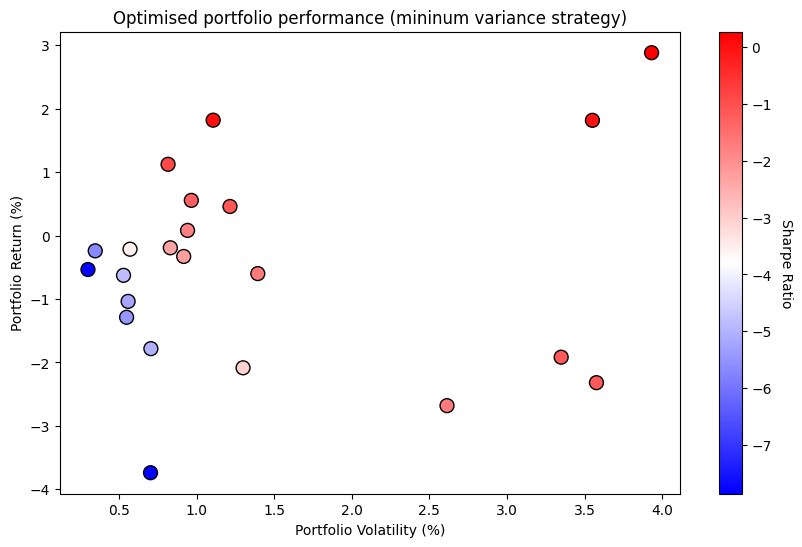

In [47]:
# Scatter plot for Minimum Variance Strategy
plt.figure(figsize=(10, 6))

# Extracting data for the minimum variance strategy
returns_minvar = np.array(results_minvar['return_p'])*100  # Portfolio returns
volatility_minvar = np.array(results_minvar['volatility_p'])*100  # Portfolio volatility
sharpe_ratios_minvar = np.array(results_minvar['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_minvar = plt.scatter(volatility_minvar, returns_minvar, c=sharpe_ratios_minvar, cmap='bwr', s=100, edgecolor='k')
cbar_minvar = plt.colorbar(sc_minvar)
cbar_minvar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Optimised portfolio performance (mininum variance strategy)')
plt.show()

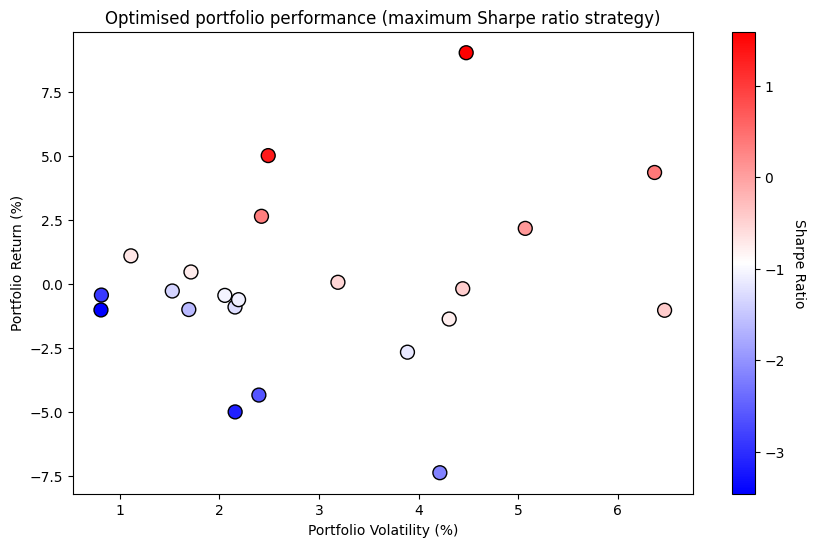

In [48]:
# Scatter plot for Maximum Sharpe Ratio Strategy
plt.figure(figsize=(10, 6))

# Extracting data for the maximum Sharpe ratio strategy
returns_maxsr = np.array(results_maxsr['return_p'])*100  # Portfolio returns
volatility_maxsr = np.array(results_maxsr['volatility_p'])*100  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_maxsr = np.array(results_maxsr['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_maxsr = plt.scatter(volatility_maxsr, returns_maxsr, c=sharpe_ratios_maxsr, cmap='bwr', s=100, edgecolor='k')
cbar_maxsr = plt.colorbar(sc_maxsr)
cbar_maxsr.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Optimised portfolio performance (maximum Sharpe ratio strategy)')
plt.show()

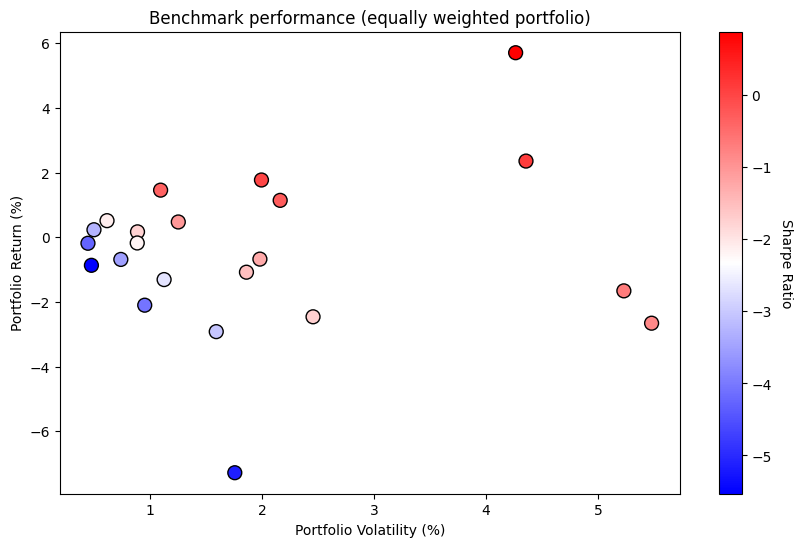

In [49]:
# Scatter plot for benchmark portfolio
plt.figure(figsize=(10, 6))

# Extracting data for benchmark
returns_b = np.array(results_maxsr['return_eqw'])*100  # Portfolio returns
volatility_b = np.array(results_maxsr['volatility_eqw'])*100  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_b = np.array(results_maxsr['sharpe_ratio_eqw'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_b = plt.scatter(volatility_b, returns_b, c=sharpe_ratios_b, cmap='bwr', s=100, edgecolor='k')
cbar_b = plt.colorbar(sc_b)
cbar_b.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Benchmark performance (equally weighted portfolio)')
plt.show()

In [50]:
#Generate dates

import pandas as pd
# The initial start date
start_date = pd.to_datetime("2019-11-01")
end_date = pd.to_datetime("2020-11-01")
start_f_date = start_date + pd.tseries.offsets.BDay(fc) #forecasting period using as step
dates_df = pd.date_range(start=start_f_date, end=end_date, periods=tperiods)
len(dates_df)

22

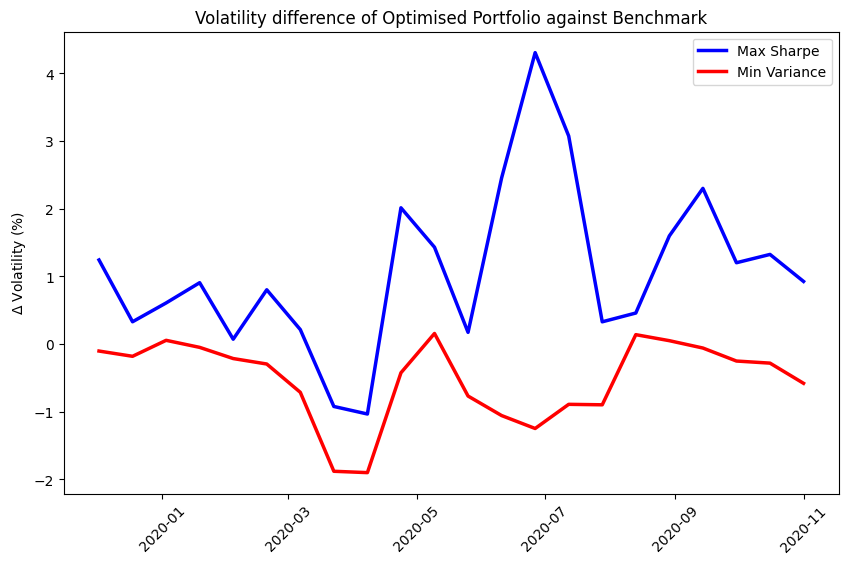

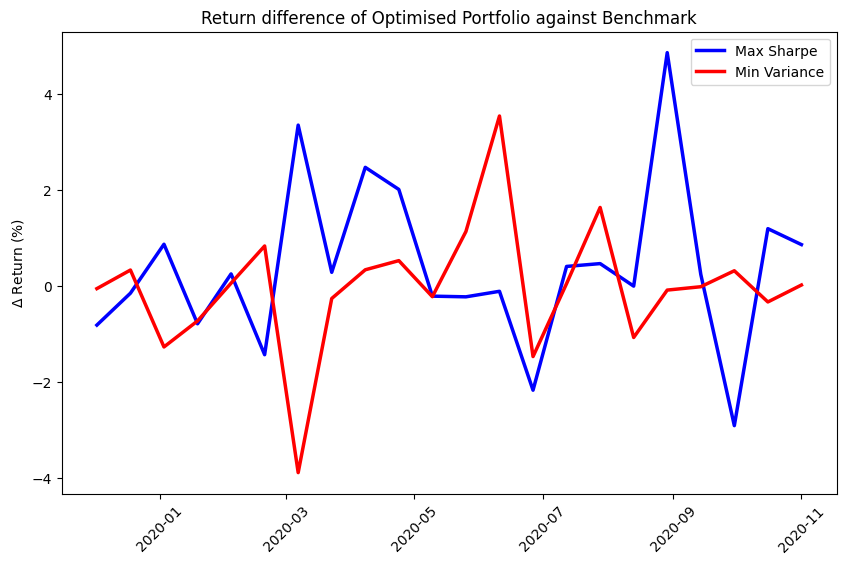

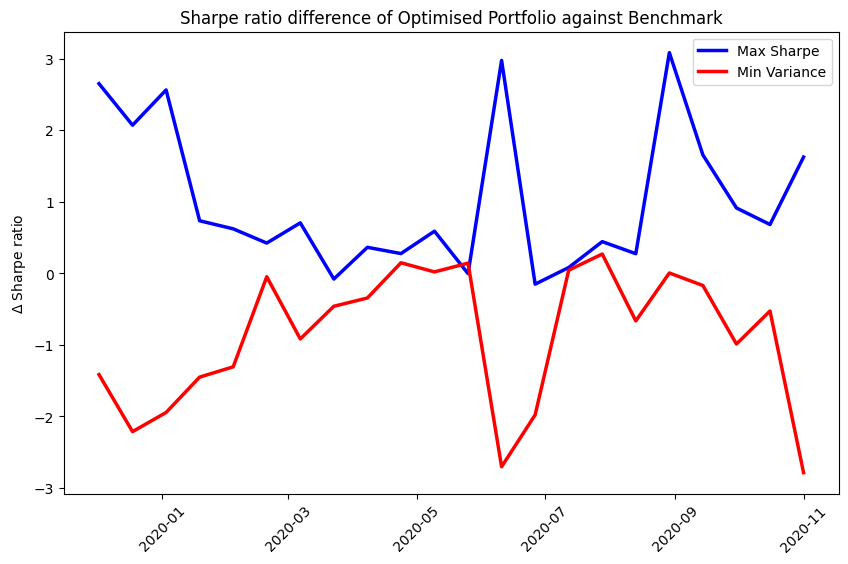

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting volatility for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, np.array(results_maxsr['volatility_diff'])*100, label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, np.array(results_minvar['volatility_diff'])*100, label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Volatility (%)")
plt.title("Volatility difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Plotting returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, np.array(results_maxsr['return_diff'])*100, label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, np.array(results_minvar['return_diff'])*100, label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Return (%)")
plt.title("Return difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting Sharpe ratio difference for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, results_maxsr['sharpe_ratio_diff'], label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, results_minvar['sharpe_ratio_diff'], label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Sharpe ratio")
plt.title("Sharpe ratio difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()